# Community-contributed embeddings

This notebook demonstrates basic access to community-contributed, CELLxGENE-hosted embeddings of the Census.

## Background

This notebook demonstrates access to community-contributed embeddings of the Census. The Census has multiple releases, named by a `census_version`, which normally looks like an ISO date, e.g., `2023-02-01`. A community-contributed embedding is a 2D sparse matrix of cell embeddings _for a given census version_, encoded as a SOMA SparseNDArray.

Each embedding is encoded as a SOMA SparseNDArray:
* dimension 0 encodes the cell (obs) `soma_joinid` value
* dimension 1 encodes the embedding feature, and is in the range [0, N)
* data is float32

Community-contributed embeddins may embed a subset of the Census version. Any cell embedded with have explicitly stored values in the embedding sparse array, _even if the embedding value is zero_. In other words, missing values imply that the cell was not embedded, whereas zero valued embeddings are explicitly stored.

## Metadata

Each embedding will contain a variety of metadata stored in the SOMA `metadata` slot, encoded as a JSON string. This metadata includes several important fields, including:
* census_version - the Census which is embedded. It is critical to confirm this matches the Census in use, or the embeddings will be meaningless.
* experiment_name - the Census experiment embedded, e.g., `homo_sapiens` or `mus_musculus`.
* measurement_name - the Census measurement embedded, e.g., `RNA`

There are a variety of other metadata values encoded, as [documented here](link???).


In [1]:
import json

import tiledbsoma as soma


def soma_context() -> soma.options.SOMATileDBContext:
    """
    Helper function. Returns a config which uses larger I/O buffers and reads from AWS S3 us-west-2 region.
    """
    return soma.options.SOMATileDBContext(
        tiledb_config={
            "soma.init_buffer_bytes": 4 * 1024**3,
            "py.init_buffer_bytes": 4 * 1024**3,
            "vfs.s3.region": "us-west-2",
        }
    )


EMBEDDING_URI = "s3://bruce-uswest-tmp/CxG-contrib-1/emb_t1/"

with soma.open(EMBEDDING_URI, context=soma_context()) as E:
    # read embedding metadata and decode the JSON-encoded data
    embedding_metadata = json.loads(E.metadata["CxG_contrib_metadata"])

census_version = embedding_metadata["census_version"]
experiment_name = embedding_metadata["experiment_name"]

embedding_metadata

{'title': 'scvi test embedding',
 'description': 'Embedding created by Emanuele, as test for SCVI\n',
 'contact_name': 'Emanuele',
 'contact_email': 'ebezzi@chanzuckerberg.com',
 'contact_affiliation': 'CZI',
 'DOI': '',
 'additional_information': '',
 'model_link': '',
 'data_type': 'obs_embedding',
 'census_version': '2023-10-09',
 'experiment_name': 'homo_sapiens',
 'measurement_name': 'RNA',
 'n_features': 200,
 'submission_date': '2023-10-30'}

## Query cells from the Census, and load their associated embeddings

This demonstrates several methods to query cells from the Census by `obs` metadata, and then fetch embeddings associated with each cell.

Demos:
1. load the embedding into a dense NumPy array
2. load the embedding into an AnnData `obsm` slot

In [2]:
# Demo 1A: select cells from the Census based on obs metadata. Given the resulting cells,
# use their soma_joinids to slice from embedding, and save as a dense NDArray.

import cellxgene_census
import numpy as np
from IPython.display import HTML, Markdown


# First, query for the cells of interest based upon metadata and save as
# a Pandas DataFrame
with cellxgene_census.open_soma(census_version=census_version) as census:
    experiment = census["census_data"][experiment_name]
    obs_df = (
        experiment.obs.read(
            value_filter="""tissue_general == 'exocrine gland'""",
            column_names=[
                "soma_joinid",
                "cell_type",
                "suspension_type",
                "tissue_general",
            ],
        )
        .concat()
        .to_pandas()
    )

display(obs_df)

# Extract embedddings for the selected cells, into a 2D NDArray of values,
# and a 1D array of joinids
with soma.open(EMBEDDING_URI, context=soma_context()) as E:
    # read embedding and obs joinids
    obs_joinids = obs_df.soma_joinid.to_numpy()

    embedding_joinids = None
    embedding_data = None
    for d, (obs_joinids, _) in E.read(coords=(obs_joinids,)).blockwise(axis=0).scipy():
        d = d.toarray()  # densify
        embedding_data = np.vstack([embedding_data, d]) if embedding_data is not None else d
        embedding_joinids = (
            np.concatenate((embedding_joinids, obs_joinids)) if embedding_joinids is not None else obs_joinids
        )

# Each cell embedding is positionally indexed
display(Markdown("## First few cells, metadata and cell embedding"))
display(obs_df.iloc[0:3])
display(embedding_data[0:3, 0:4])

,soma_joinid,cell_type,suspension_type,tissue_general
0,5106256,acinar cell of salivary gland,cell,exocrine gland
1,5106257,acinar cell of salivary gland,cell,exocrine gland
2,5106258,naive B cell,cell,exocrine gland
3,5106259,memory B cell,cell,exocrine gland
4,5106260,memory B cell,cell,exocrine gland
...,...,...,...,...
115717,49346681,acinar cell of salivary gland,cell,exocrine gland
115718,49346682,duct epithelial cell,cell,exocrine gland
115719,49346683,acinar cell of salivary gland,cell,exocrine gland
115720,49346684,duct epithelial cell,cell,exocrine gland


## First few cells, metadata and cell embedding

,soma_joinid,cell_type,suspension_type,tissue_general
0,5106256,acinar cell of salivary gland,cell,exocrine gland
1,5106257,acinar cell of salivary gland,cell,exocrine gland
2,5106258,naive B cell,cell,exocrine gland


array([[-0.05037862, -0.8743975 ,  1.0350506 ,  0.00919673],
       [-0.2436011 , -0.03163528,  0.4832609 , -0.00560813],
       [-0.64155304, -0.1629573 , -0.78658855, -0.0100923 ]],
      dtype=float32)

In [3]:
# Demo 1B: The same method can be used to query an AnnData from the Census, and
# add the embedding as an `obsm` layer on the AnnData.

with cellxgene_census.open_soma(census_version=census_version) as census:
    experiment = census["census_data"][experiment_name]
    with experiment.axis_query(
        measurement_name="RNA",
        obs_query=soma.AxisQuery(value_filter="tissue_general in ['heart','intestine']"),
        var_query=soma.AxisQuery(coords=(slice(0, 1),)),  # we don't use X data, so minimize load memory & time
    ) as query:
        # Load AnnData and X[raw]
        ad = query.to_anndata(X_name="raw")

        # Load embedding associated with the obs joinids
        with soma.open(EMBEDDING_URI, context=soma_context()) as E:
            # read embedding and obs joinids
            embedding_data = np.vstack(
                list(
                    blk.toarray()
                    for blk, _ in E.read(coords=(query.obs_joinids().to_numpy(),))
                    .blockwise(axis=0, size=2**20, reindex_disable_on_axis=1)
                    .scipy(compress=False)
                )
            )

        # Save as an obsm layer
        ad.obsm["an_embedding"] = embedding_data

ad

AnnData object with n_obs × n_vars = 3224599 × 2
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'an_embedding'

/home/bruce/cellxgene-census/venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


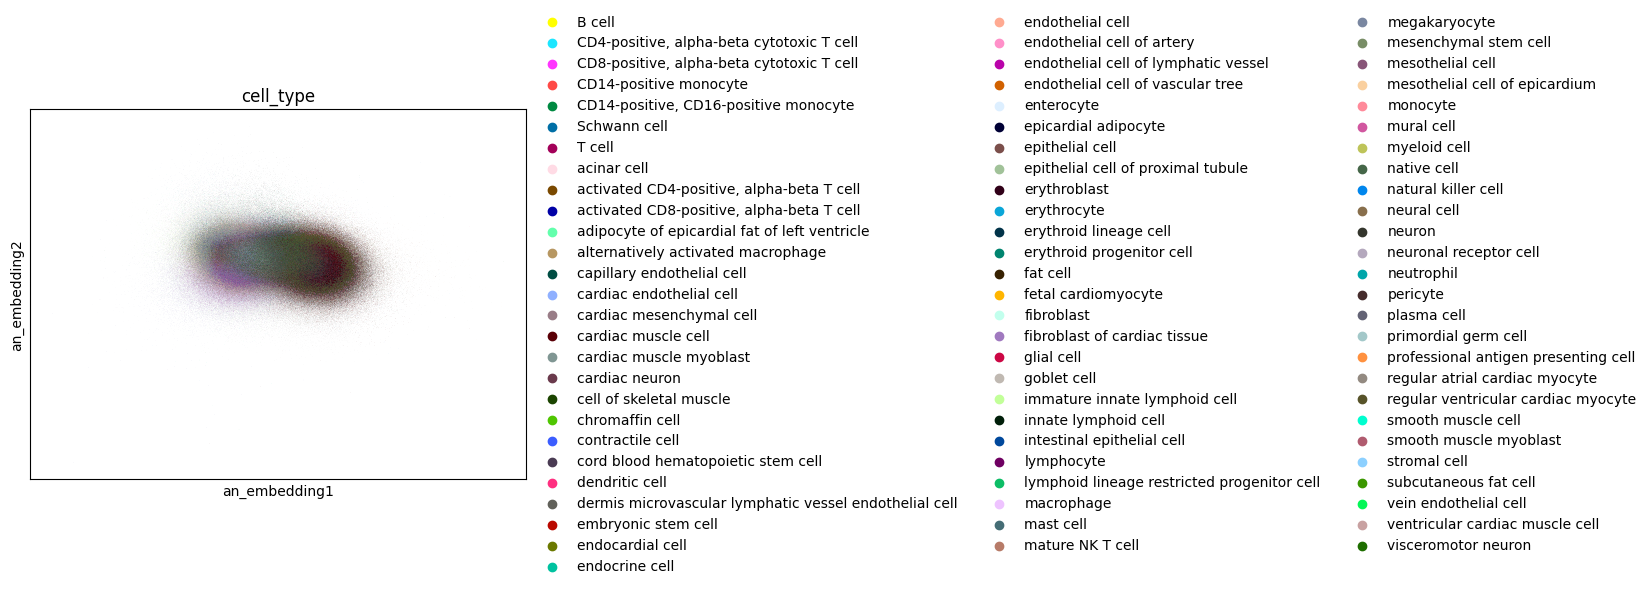

In [4]:
# plot with ScanPy
import scanpy
scanpy.pl.embedding(ad, "an_embedding", color='cell_type')

## Load the embedding, and fetch Census data associated with each embedding

This method starts with the loaded embedding, and for each embedded cell loads metadata or X data.


In [5]:
# Load the entire embedding (caution: embeddings can be quite large)
with soma.open(EMBEDDING_URI, context=soma_context()) as E:
    # read embedding and obs joinids for each embedded cell

    n_features = E.shape[1]
    embedding_joinids = None  # 1D array of joinids
    embedding_data = None  # 2D array of embedding values
    joinids = []  # 1D array of joinids
    data = []  # 2D array of embedding values


    # Use the table reader, as it is faster than the SciPy reader. Disable reindexing on second
    # dimension, as second dimension coordates are always [0...N) for embeddings.
    for tbl, (obs_joinids, _) in E.read().blockwise(axis=0, size=2**20, reindex_disable_on_axis=1).tables():
        # convert table i,j,d to dense ndarray
        i = tbl.column("soma_dim_0").to_numpy()
        j = tbl.column("soma_dim_1").to_numpy()
        d = tbl.column("soma_data").to_numpy()
        e = np.empty((len(obs_joinids), n_features), dtype=np.float32)
        e.put(i * e.shape[1] + j, d)

        data.append(e)
        joinids.append(obs_joinids)

    # concat block of data and coordinates
    embedding_data = np.vstack(data)
    embedding_joinids = np.concatenate(joinids)

# Load the associated metadata - in this case, obs.suspension_type
with cellxgene_census.open_soma(census_version=census_version) as census:
    experiment = census["census_data"][experiment_name]
    with experiment.axis_query(measurement_name="RNA", obs_query=soma.AxisQuery(coords=(embedding_joinids,))) as query:
        obs_df = query.obs(column_names=["soma_joinid", "suspension_type"]).concat().to_pandas()

# Display the first few cells, and the first few columns of their embeddings
display(obs_df[0:3])
display(embedding_data[0:3, 0:10])

,soma_joinid,suspension_type
0,0,nucleus
1,1,nucleus
2,2,nucleus


array([[-0.1315444 ,  0.05968512, -0.54940224,  0.01145068,  0.04101296,
         0.31383532, -0.02826622, -1.4952054 , -0.96443677, -0.18853365],
       [-0.89719796,  0.5004858 , -1.1795582 ,  0.02101215, -0.35938275,
        -0.34972638,  0.00611238, -0.5238733 , -0.9806414 , -0.87285537],
       [-0.89847916,  0.6852382 , -0.88130176, -0.00819424,  0.03000421,
         0.6847874 ,  0.00241117, -0.7786879 , -0.78590053, -1.0146879 ]],
      dtype=float32)